In [2]:
import json
import numpy as np
import skimage as sk
import skimage.io as skio
from matplotlib import pyplot as plt
import cv2 as cv
from scipy.interpolate import griddata
from skimage.transform import resize, rescale
from scipy.signal import convolve2d
from scipy.ndimage import distance_transform_edt
from skimage.feature import corner_harris, peak_local_max
from skimage.color import rgb2gray

## **Part A**

In [220]:
im_left = sk.img_as_float(plt.imread('heyns/heyns_left.jpg') / 255)
im_mid = sk.img_as_float(plt.imread('heyns/heyns_mid.jpg') / 255)
im_right = sk.img_as_float(plt.imread('heyns/heyns_right.jpg') / 255)

with open('heyns/heyns_mid_heyns_left.json') as f:
    correspondences = json.load(f)
    points1 = np.array(correspondences[f'im1Points'])
    points2 = np.array(correspondences[f'im2Points'])

with open('heyns/heyns_mid_heyns_right.json') as f:
    correspondences = json.load(f)
    points3 = np.array(correspondences[f'im1Points'])
    points4 = np.array(correspondences[f'im2Points'])

In [221]:
# Downsample the images (resolution too large)
alpha = 0.25

def scale_down(im, alpha):
    # Get the original dimensions
    if len(im.shape) == 3:
        h, w, _ = im.shape
    elif len(im.shape) == 2:
        h, w = im.shape
    
    # Calculate new dimensions (% of the original size)
    new_h, new_w = int(h * alpha), int(w * alpha)
    # new_h, new_w = max(1, int(round(h * alpha))), max(1, int(round(w * alpha)))
    
    # Resize the image
    scaled_image = resize(im, (new_h, new_w), anti_aliasing=True)
    
    return scaled_image

im_left = scale_down(im_left, alpha)
im_mid = scale_down(im_mid, alpha)
im_right = scale_down(im_right, alpha)

points1 = points1 * alpha
points2 = points2 * alpha
points3 = points3 * alpha
points4 = points4 * alpha

### Corresponding points

In [156]:
# Create plot with corresponsing points
def plot_images_with_correspondences(im1, im2, points1, points2, fpath, gap_size=50):
    gap = np.ones((im1.shape[0], gap_size, 3))

    im_combined = np.concatenate((im1, gap, im2), axis=1)
    points2_shifted = points2.copy()
    points2_shifted[:, 0] += im1.shape[1] + gap_size

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.imshow(im_combined)
    ax.set_aspect('equal')
    ax.axis('off')

    # Plot the points on the first and second images
    ax.scatter(points1[:, 0], points1[:, 1], c='r', marker='o', s=30)
    ax.scatter(points2_shifted[:, 0], points2_shifted[:, 1], c='r', marker='o', s=30)

    # Plot lines connecting corresponding points
    for p1, p2 in zip(points1, points2_shifted):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'r-', lw=2)

    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(fpath, bbox_inches='tight', pad_inches=0)

# plot_images_with_correspondences(im_mid, im_left, points1, points2, 'street/results/left_pts.jpg')

### Recover homographies

In [157]:
def computeH(im1_pts, im2_pts):
    n_points = im1_pts.shape[0]
    A, b = [], []
    
    for i in range(n_points):
        x, y = im1_pts[i][0], im1_pts[i][1]
        x_prime, y_prime = im2_pts[i][0], im2_pts[i][1]
        A.append([x, y, 1, 0, 0, 0, -x * x_prime, -y * x_prime])
        b.append(x_prime)
        A.append([0, 0, 0, x, y, 1, -x * y_prime, -y * y_prime])
        b.append(y_prime)
    
    A = np.array(A)
    b = np.array(b)
    
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    
    H = np.array([[h[0], h[1], h[2]],
                  [h[3], h[4], h[5]],
                  [h[6], h[7], 1]])
    
    return H

### Warping

In [158]:
def warped_dimensions(im, H):
    h, w = im.shape[:2]
    corners = np.array([[0, 0, 1], [w, 0, 1], [0, h, 1], [w, h, 1]])
    
    transformed_corners = np.dot(H, corners.T).T
    transformed_corners /= transformed_corners[:, 2][:, np.newaxis]  # Normalize

    min_x, min_y = np.min(transformed_corners[:, :2], axis=0)
    max_x, max_y = np.max(transformed_corners[:, :2], axis=0)
    
    new_w = int(np.ceil(max_x - min_x))
    new_h = int(np.ceil(max_y - min_y))

    shift_x = -min_x
    shift_y = -min_y

    return (new_w, new_h), (shift_x, shift_y)

In [171]:
def warp(im, H, crop=True):
    if crop:
        dimension, displacement = warped_dimensions(im, H)
    else:
        dimension = (im.shape[1], im.shape[0])
        displacement = (0, 0)
        
    new_w, new_h = dimension
    shift_x, shift_y = displacement

    # warped_im = np.zeros((new_h, new_w, im.shape[2]), dtype=im.dtype)
    if len(im.shape) == 2:  # Grayscale image
        warped_im = np.zeros((new_h, new_w), dtype=im.dtype)
    else:  # Color image
        warped_im = np.zeros((new_h, new_w, im.shape[2]), dtype=im.dtype)

    H_inv = np.linalg.inv(H)

    x_coords, y_coords = np.meshgrid(np.arange(new_w), np.arange(new_h))
    p_prime = np.vstack([x_coords.ravel() - shift_x, y_coords.ravel() - shift_y, np.ones(new_w * new_h)])
    p = np.dot(H_inv, p_prime)
    p /= p[2]
    
    src_x = p[0].reshape(new_h, new_w)
    src_y = p[1].reshape(new_h, new_w)

    valid_mask = (src_x >= 0) & (src_x < im.shape[1]) & (src_y >= 0) & (src_y < im.shape[0])
    
    src_x = np.floor(src_x).astype(int)
    src_y = np.floor(src_y).astype(int)
    
    warped_im[valid_mask] = im[src_y[valid_mask], src_x[valid_mask]]

    return warped_im, dimension, displacement


(1676, 1350) (np.float64(555.3915139623351), np.float64(182.88301345710596))


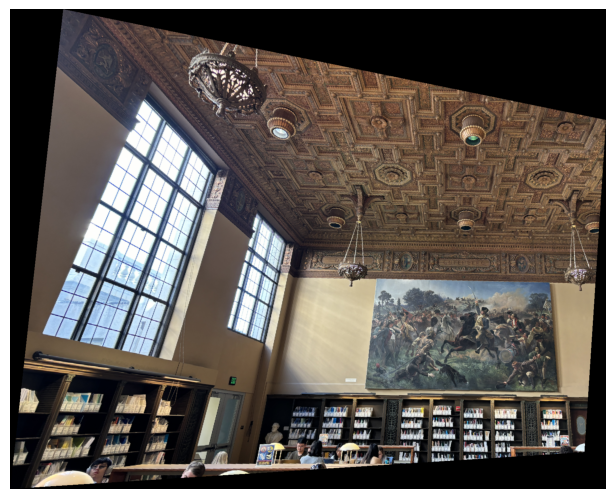

In [64]:
H_left = computeH(points2, points1)
warped_left, dimension_left, displacement_left = warp(im_left, H_left)

plt.imshow(warped_left)
plt.axis('off')
plt.tight_layout(pad=0)
# plt.savefig('heyns/results/left_warped.jpg', bbox_inches='tight', pad_inches=0)
print(dimension_left, displacement_left)

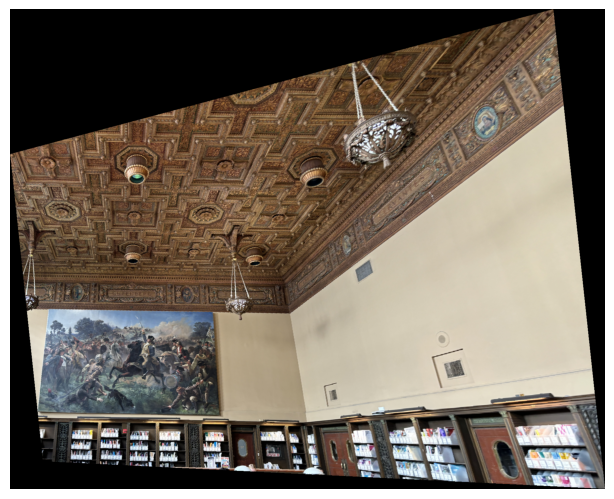

In [33]:
H_right = computeH(points4, points3)
warped_right, dimension_right, displacement_right = warp(im_right, H_right)

plt.imshow(warped_right)
plt.axis('off')
plt.tight_layout(pad=0)
# plt.savefig('street/results/right_warped.jpg', bbox_inches='tight', pad_inches=0)

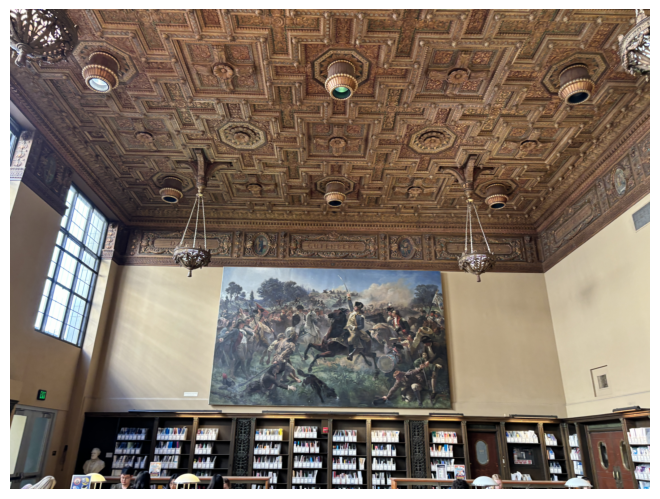

In [34]:
plt.imshow(im_mid)
plt.axis('off')
plt.tight_layout(pad=0)
# plt.savefig('street/results/mid.jpg', bbox_inches='tight', pad_inches=0)

### Rectification

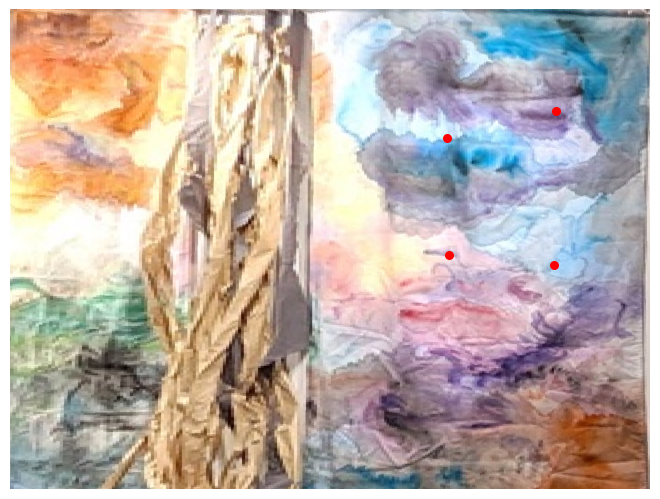

In [11]:
im_rect = sk.img_as_float(plt.imread('rectification/gallery.jpg') / 255)

with open('rectification/gallery_gallery.json') as f:
    correspondences = json.load(f)
    points = np.array(correspondences[f'im1Points'])
    
def rectify(im, pts):
    height, width = im.shape[:2]
    rect_pts = np.array([[0, 0], [width, 0], [0, height - 1], [width, height - 1]])
    H = computeH(pts, rect_pts)
    
    plt.imshow(im)
    plt.scatter(pts[:, 0], pts[:, 1], c='r', marker='o', s=30)
    plt.axis('off')
    plt.tight_layout(pad=0)
    # plt.savefig('rectification/results/gallery_pts.jpg', bbox_inches='tight', pad_inches=0)

    warped_im, _, _ = warp(im, H, False)
    return warped_im

warped_gallery = rectify(im_rect, points)
plt.imshow(warped_gallery)
plt.axis('off')
plt.tight_layout(pad=0)
# plt.savefig('rectification/results/gallery_rect.jpg', bbox_inches='tight', pad_inches=0)
plt.show()

### Mosaic

In [173]:
# Blending
def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)

# Low-pass filter function
def apply_low_pass(image, sigma):
    kernel_size = int(6 * sigma)
    gaussian_kernel = cv.getGaussianKernel(ksize=kernel_size, sigma=sigma)
    gaussian_2d = gaussian_kernel @ gaussian_kernel.T
    filtered_image = cv.filter2D(image, -1, gaussian_2d)
    return filtered_image

# Function to create a Gaussian stack
def generate_gaussian_stack(image, num_layers, sigma):
    gaussian_stack = [image]
    for i in range(1, num_layers):
        current_sigma = sigma * (2 ** i)
        blurred_image = apply_low_pass(gaussian_stack[-1], current_sigma)
        gaussian_stack.append(blurred_image)
    return gaussian_stack

# Function to create a Laplacian stack
def generate_laplacian_stack(gaussian_stack):
    laplacian_stack = []
    for i in range(len(gaussian_stack) - 1):
        laplacian_image = gaussian_stack[i] - gaussian_stack[i + 1]
        laplacian_stack.append(laplacian_image)
    laplacian_stack.append(gaussian_stack[-1])  # Add the last Gaussian image
    return laplacian_stack

# Blending function
def blend(im1_warped, im2, num_layers=2, sigma=11):
    mask1 = np.any(im1_warped != 0, axis=2).astype(np.uint8)
    mask2 = np.any(im2 != 0, axis=2).astype(np.uint8)

    dist_mask1 = distance_transform_edt(mask1)
    dist_mask2 = distance_transform_edt(mask2)

    overlap_mask = dist_mask1 > dist_mask2
    overlap_mask = overlap_mask.astype(np.float32)

    color_mask = np.stack([overlap_mask] * 3, axis=-1)

    gaussian_stack1 = generate_gaussian_stack(im1_warped, num_layers, sigma)
    gaussian_stack2 = generate_gaussian_stack(im2, num_layers, sigma)

    laplacian_stack1 = generate_laplacian_stack(gaussian_stack1)
    laplacian_stack2 = generate_laplacian_stack(gaussian_stack2)

    masks = generate_gaussian_stack(color_mask, num_layers, sigma)

    for i in range(len(masks)):
        laplacian_stack1[i] *= masks[i]  # Apply mask to Laplacian stack
        laplacian_stack2[i] *= (1. - masks[i])  # Inverse mask for second image

    # Combine masked images
    masked_image1 = np.sum(laplacian_stack1, axis=0)
    masked_image2 = np.sum(laplacian_stack2, axis=0)

    blended_image = masked_image1 + masked_image2
    return blended_image

In [175]:
def create_mosaic(warped_left, warped_right, im_mid, dimension_left, displacement_left, dimension_right, displacement_right):
    canvas_w = int(max(dimension_left[1] + displacement_left[1] + dimension_right[1], im_mid.shape[1] + dimension_left[1] + displacement_left[1] + dimension_right[1]))
    canvas_h = int(max(dimension_left[0] + displacement_left[0], dimension_right[0] + displacement_right[0], im_mid.shape[0]))

    mosaic = np.zeros((canvas_h, canvas_w, 3))

    canvas_left = np.zeros((canvas_h, canvas_w, 3))
    canvas_left[:warped_left.shape[0], :warped_left.shape[1], :] = warped_left

    canvas_right = np.zeros((canvas_h, canvas_w, 3))
    canvas_right[:warped_right.shape[0], :warped_right.shape[1], :] = warped_right

    canvas_mid = np.zeros((canvas_h, canvas_w, 3))
    canvas_mid[:im_mid.shape[0], :im_mid.shape[1], :] = im_mid

    canvas_mid = np.roll(canvas_mid, (int(displacement_left[0]), int(displacement_left[1])), axis=(1, 0))
    canvas_right = np.roll(canvas_right, (int(displacement_left[0] - displacement_right[0]), int(displacement_left[1] - displacement_right[1])), axis=(1, 0))

    # Blend the canvases
    canvas_left = blend(canvas_left, canvas_mid)
    canvas_right = blend(canvas_right, canvas_mid)

    # Blend both canvases
    mosaic = blend(canvas_left, canvas_right)

    # Crop the mosaic
    mosaic = mosaic[:round(canvas_h * 0.5), :round(canvas_w * 0.6), :]

    return mosaic, canvas_left, canvas_mid, canvas_right

# mosaic, canvas_left, canvas_mid, canvas_right = create_mosaic(warped_left, warped_right, im_mid, dimension_left, displacement_left, dimension_right, displacement_right)
# plt.imshow(mosaic)
# plt.axis('off')
# plt.tight_layout(pad=0)
# plt.savefig('heyns/results/blended_mosaic.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)

# **Part b**

### Harris interest point detector

In [222]:
# This code was provided to us
def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=1)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords

def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert dimx == dimc, 'Data dimension does not match dimension of centers'

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

In [245]:
im1 = rgb2gray(im_mid)
im2 = rgb2gray(im_left)

h1, coords1 = get_harris_corners(im1)
h2, coords2 = get_harris_corners(im2)

threshold = 2000 # Keep only the top 2000 corners
top_coords1, top_coords2 = coords1[:, :threshold], coords2[:, :threshold]

### Adaptive Non-Maximal Suppression (ANMS)

In [246]:
def ANMS(h_vals, corners, num_points=500, comp_ratio=0.9, search_radius=100):
    # Initialize the result arrays
    height, width = h_vals.shape
    main_res, backup_res = [], []
    max_val = np.max(h_vals)
    
    for y, x in corners:
        if h_vals[y][x] >= max_val:
            main_res.append((y, x, float('inf')))
            continue

        threshold_val = h_vals[y][x] / comp_ratio
        search_bounds = [max(0, y - search_radius), min(height - 1, y + search_radius), max(0, x - search_radius), min(width - 1, x + search_radius)]

        local_mask = np.array(np.where(h_vals[search_bounds[0]:search_bounds[1], search_bounds[2]:search_bounds[3]] > threshold_val)).T
        local_mask += np.array([search_bounds[0], search_bounds[2]])

        if len(local_mask) > 0:
            backup_res.append((y, x, np.min(dist2(local_mask, np.array([[y, x]])).flatten())))
            continue

        full_mask = np.array(np.where(h_vals > threshold_val)).T
        if len(full_mask) == 0:
            main_res.append((y, x, float('inf')))
        else:
            main_res.append((y, x, np.min(dist2(full_mask, np.array([[y, x]])).flatten())))

    # Sort by distance for main_res and limit by num_points
    main_res.sort(key=lambda item: item[-1], reverse=True)
    if len(main_res) > num_points:
        return np.array(main_res[:num_points])[:, :-1].astype(np.int32)

    # Sorting backup list and combining results if main_res is short
    backup_res.sort(key=lambda item: item[-1], reverse=True)
    combined_res = []
    for idx, entry in enumerate(main_res):
        if entry[2] > backup_res[0][2]:
            combined_res.append(entry)
        else:
            main_res = main_res[idx:]
            break

    # Append remaining entries to the result
    backup_res = main_res + backup_res
    backup_res.sort(key=lambda item: item[-1], reverse=True)
    return np.array(combined_res + backup_res[:num_points - len(combined_res)])[:, :-1].astype(np.int32)

anms1 = ANMS(h1, coords1.T)
anms2 = ANMS(h2, coords2.T)
print(anms1.shape, anms2.shape)

(500, 2) (500, 2)


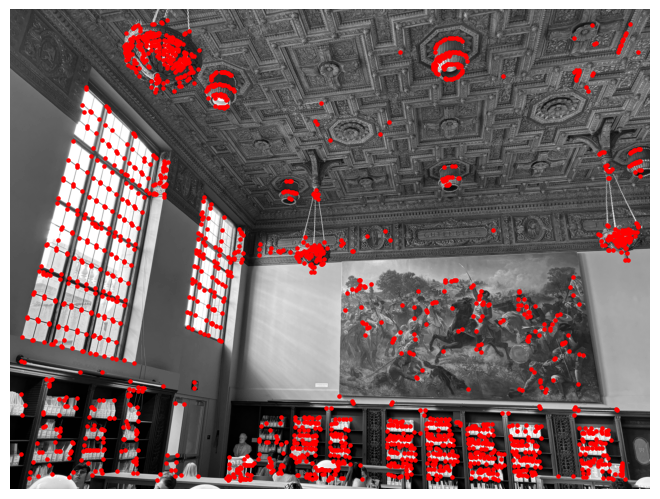

In [239]:
# plt.imshow(im2, cmap='gray')
# plt.scatter(top_coords2.T[:, 1], top_coords2.T[:, 0], s=5, c='r')
# plt.axis('off')
# plt.tight_layout(pad=0)
# plt.savefig('anms/im_left_NO_ANMS.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)

### Feature descriptor extractor

In [162]:
def get_descriptor(im, coord, window=40, scale=5):
    y, x = coord[0], coord[1]
    half_window = window // 2
    sample_window = im[y - half_window:y + half_window, x - half_window:x + half_window]
    scaled_window = scale_down(sample_window, 1/scale)
    mu = np.mean(scaled_window)
    sigma = np.std(scaled_window)
    feature_descriptor = (scaled_window - mu) / sigma
    return feature_descriptor

### Feature matching

In [163]:
def match_points(im1, im2, coords1, coords2):
    descriptors1 = np.array([get_descriptor(im1, coord).flatten() for coord in coords1.T])
    descriptors2 = np.array([get_descriptor(im2, coord).flatten() for coord in coords2.T])
    dists = dist2(descriptors1, descriptors2)
    thld = 0.4

    matches = []
    for i in range(descriptors1.shape[0]):
        distances_for_i = dists[i]
        indices = np.argsort(distances_for_i)
        if distances_for_i[indices[0]] / distances_for_i[indices[1]] <= thld:
            matches.append((i, indices[0]))

    matches = np.array(matches)
    return matches

In [247]:
# # Plot corresponding points after feature matching
# m, n = im1.shape
matches = match_points(im1, im2, top_coords1, top_coords2)

# combinedImg = np.empty((m, 2*n))
# combinedImg[:,:n] = im1
# combinedImg[:,n:] = im2

# plt.imshow(combinedImg, cmap='gray')
# for i in range(len(matches)):
#     p1, p2 = coords1.T[matches[i][0]], coords2.T[matches[i][1]]
#     plt.plot([p1[1], n+p2[1]], [p1[0], p2[0]], linewidth=0.5, color='r')

# plt.axis('off')
# plt.tight_layout(pad=0)
# # plt.savefig('feature_matching/corresponding_points.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)
# print("Number of matches:", len(matches))

### 4-Point Random Sample Consensus (RANSAC)

In [167]:
# Visualization of inliers and matches
def plot_matches(image1, image2, points1, points2, inliers=None):
    plt.imshow(image1, cmap='gray')
    plt.scatter(points1[:, 0], points1[:, 1], color='y', s=5)
    if inliers is not None:
        plt.scatter(points1[inliers, 0], points1[inliers, 1], color='r', s=5)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('ransac/im_mid_RANSAC.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)
    plt.show()

    plt.imshow(image2, cmap='gray')
    plt.scatter(points2[:, 0], points2[:, 1], color='y', s=5)
    if inliers is not None:
        plt.scatter(points2[inliers, 0], points2[inliers, 1], color='r', s=5)    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('ransac/im_left_RANSAC.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)

# plot_matches(im1, im2, p[:, :2], p_prime[:, :2], best_inliers)

In [256]:
def RANSAC(coords1, coords2, matches, iters=1000, threshold=0.5):
    num_pts, best_inliers, best_H = 0, None, None

    # Swap [y, x] -> [x, y]
    matched_coords1 = np.roll(coords1[:, matches[:, 0]], 1, axis=0)
    matched_coords2 = np.roll(coords2[:, matches[:, 1]], 1, axis=0)

    p = np.vstack((matched_coords1, np.ones(matched_coords1.shape[1]))).T
    p_prime = np.vstack((matched_coords2, np.ones(matched_coords2.shape[1]))).T

    for i in range(iters):
        # Randomly select 4 points
        sample_indices = np.random.choice(len(p), 4, replace=False)
        sample_pts1 = p[sample_indices]
        sample_pts2 = p_prime[sample_indices]
        
        # Compute homography
        H = computeH(sample_pts1[:, :2], sample_pts2[:, :2])
        
        # Calculate inliers
        projected_pts = (H @ p.T).T
        projected_pts /= projected_pts[:, 2][:, np.newaxis]
        dists = np.linalg.norm(projected_pts[:, :2] - p_prime[:, :2], axis=1)
        inliers = dists < threshold

        # Update best inliers
        num_inliers = np.sum(inliers)
        if num_inliers > num_pts:
            num_pts = num_inliers
            best_inliers = inliers
            best_H = H

    # Recompute best H with inliers
    fp1_inliers = p[best_inliers, :2]
    fp2_inliers = p_prime[best_inliers, :2]
    best_H = computeH(fp2_inliers, fp1_inliers)

    plot_matches(im1, im2, p[:, :2], p_prime[:, :2], best_inliers)

    return best_H, num_pts

### Putting everything together... Feature matching and Autostitching

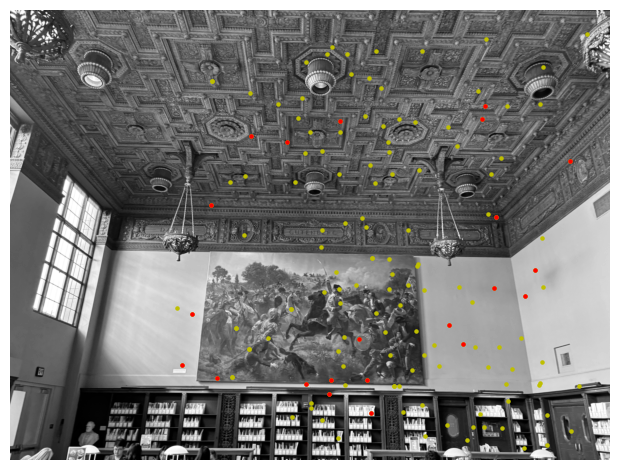

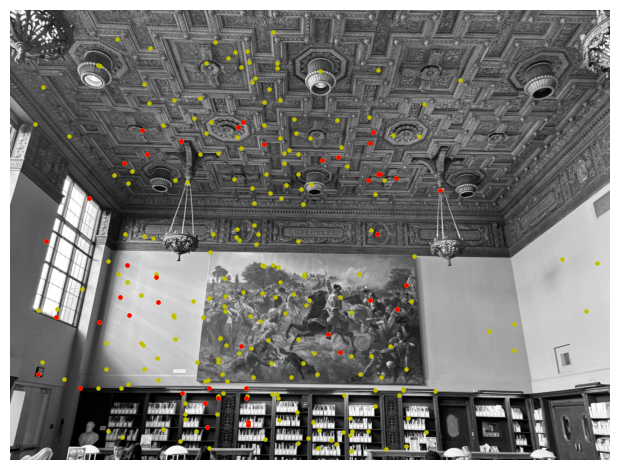

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03879186529893883..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03879186529893883..1.0].


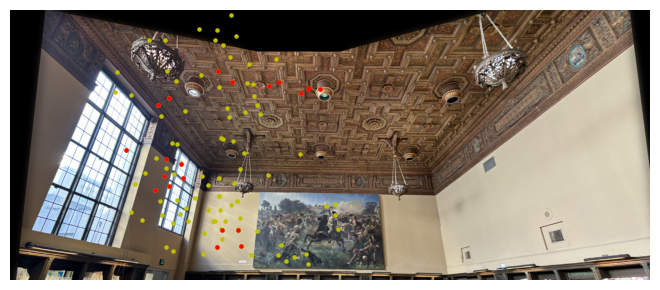

In [254]:
def autoStitch(im_left, im_mid, im_right):
    im_mid_gray = rgb2gray(im_mid)
    im_left_gray = rgb2gray(im_left)
    im_right_gray = rgb2gray(im_right)
    harris_mid, coords_mid = get_harris_corners(im_mid_gray)
    harris_left, coords_left = get_harris_corners(im_left_gray)
    harris_right, coords_right = get_harris_corners(im_right_gray)
    anms_mid = ANMS(harris_mid, coords_mid.T).T
    anms_left = ANMS(harris_left, coords_left.T).T
    anms_right = ANMS(harris_right, coords_right.T).T

    matches_left = match_points(im_mid_gray, im_left_gray, anms_mid, anms_left)
    matches_right = match_points(im_mid_gray, im_right_gray, anms_mid, anms_right)

    H_left, _ = RANSAC(anms_mid, anms_left, matches_left)
    warped_left, dimension_left, displacement_left = warp(im_left, H_left)

    H_right, _ = RANSAC(anms_mid, anms_right, matches_right)
    warped_right, dimension_right, displacement_right = warp(im_right, H_right)

    mosaic, canvas_left, canvas_mid, canvas_right = create_mosaic(warped_left, warped_right, im_mid, dimension_left, displacement_left, dimension_right, displacement_right)
    
    plt.imshow(mosaic)
    plt.axis('off')
    plt.tight_layout(pad=0)
    # plt.savefig('autostitch/heyns/mosaic.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)

    plt.imshow(warped_left)
    plt.axis('off')
    plt.tight_layout(pad=0)
    # plt.savefig('autostitch/heyns/warped_left.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)

    plt.imshow(warped_right)
    plt.axis('off')
    plt.tight_layout(pad=0)
    # plt.savefig('autostitch/heyns/warped_right.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)

    return mosaic

im_left = sk.img_as_float(plt.imread('heyns/heyns_left.jpg') / 255)
im_mid = sk.img_as_float(plt.imread('heyns/heyns_mid.jpg') / 255)
im_right = sk.img_as_float(plt.imread('heyns/heyns_right.jpg') / 255)

alpha = 0.25
im_left = scale_down(im_left, alpha)
im_mid = scale_down(im_mid, alpha)
im_right = scale_down(im_right, alpha)

final_mosaic = autoStitch(im_left, im_mid, im_right)
plt.imshow(final_mosaic)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [182]:
# heyns_manual = sk.img_as_float(plt.imread('heyns/results/blended_mosaic.jpg') / 255)
# heyns_auto = sk.img_as_float(plt.imread('autostitch/heyns/mosaic.jpg') / 255)
# plt.imshow(heyns_auto[2400:2700, 3400:3700])
# plt.axis('off')
# plt.tight_layout(pad=0)
# plt.savefig('autostitch/heyns/zoomed_auto2.jpg', bbox_inches='tight', pad_inches=0, dpi=1000)

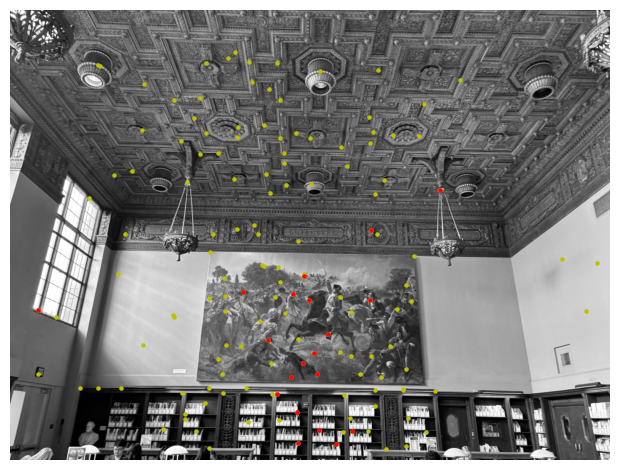

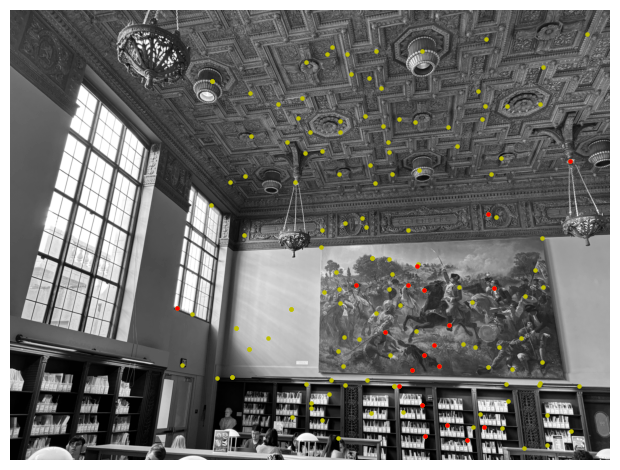

In [257]:
im_mid_gray = rgb2gray(im_mid)
im_left_gray = rgb2gray(im_left)
harris_mid, coords_mid = get_harris_corners(im_mid_gray)
harris_left, coords_left = get_harris_corners(im_left_gray)
anms_mid = ANMS(harris_mid, coords_mid.T).T
anms_left = ANMS(harris_left, coords_left.T).T
matches_left = match_points(im_mid_gray, im_left_gray, anms_mid, anms_left)
H_left, _ = RANSAC(anms_mid, anms_left, matches_left)